In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
conda install -c conda-forge scikit-plot

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install yfinance
!pip install investpy
!pip install pykrx
!pip install seaborn
!pip install workalendar
!pip install --upgrade finance-datareader
!pip install TA_Lib-0.4.19-cp38-cp38-win_amd64.whl
!pip install -U finance-datareader
!pip install keras

You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


Processing c:\users\user\downloads\ta_lib-0.4.19-cp38-cp38-win_amd64.whl
TA-Lib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


In [4]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
# 크롤링 start_date, end_date
#start_date='2017-01-05'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
#end_date='2021-01-01'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')
#train_date = '2020-01-01'
start_date = '2005-01-01'
end_date = '2021-01-19'
train_date = '2019-01-01'

In [6]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [7]:
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# Russell 2000
russell_2000_ = yf.download("^RUT", start=start_date, end=end_date)
russell_2000_.columns = ['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Close','russell_2000_Adj Close','russell_2000_Volume']
russell_2000_ = russell_2000_.drop(['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Adj Close','russell_2000_Volume'], axis=1)

# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

MSCI_KR = fdr.DataReader('156080', start_date,end_date) #MSCI KOREA
MSCI_KR = MSCI_KR.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
MSCI_KR.columns = ['MSCI_KR']

# HANG SENG
hang_seng_ = yf.download("^HSI", start=start_date, end=end_date)
hang_seng_.columns = ['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Close','hang_seng_Adj Close','hang_seng_Volume']
hang_seng_ = hang_seng_.drop(['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Adj Close','hang_seng_Volume'], axis=1)

# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)

# 미국 국채 수익률 (10년)
treasury_10y_ = yf.download("^TNX", start=start_date, end=end_date)
treasury_10y_.columns = ['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Close','treasury_10y_Adj Close','treasury_10y_Volume']
treasury_10y_ = treasury_10y_.drop(['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Adj Close','treasury_10y_Volume'], axis=1)

# 미국 국채 수익률 (30년)
treasury_30y_ = yf.download("^TYX", start=start_date, end=end_date)
treasury_30y_.columns = ['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Close','treasury_30y_Adj Close','treasury_30y_Volume']
treasury_30y_ = treasury_30y_.drop(['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Adj Close','treasury_30y_Volume'], axis=1)

# [*에너지*]
# WTI유 시세
crude_oil_ = yf.download("CL=F", start=start_date, end=end_date)
crude_oil_.columns = ['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Close','crude_oil_Adj Close','crude_oil_Volume']
crude_oil_ = crude_oil_.drop(['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Adj Close','crude_oil_Volume'], axis=1)

# 브렌트유 시세
brent_crude_oil_ = yf.download("BZ=F", start=start_date, end=end_date)
brent_crude_oil_.columns = ['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Close','brent_crude_oil_Adj Close','brent_crude_oil_Volume']
brent_crude_oil_ = brent_crude_oil_.drop(['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Adj Close','brent_crude_oil_Volume'], axis=1)

# SOX 지수 엔비디아(8.9%), 텍사스인스트루먼트(8.6%), 퀄컴(7.7%), 인텔(7.4%) 반도체장비기업 18.52%
SOXX = yf.download("SOXX", start=start_date, end=end_date)
SOXX.columns = ['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Close','SOXX_Adj Close','SOXX_Volume']
SOXX = SOXX.drop(['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Adj Close','SOXX_Volume'], axis=1)

# SMH 인텔(10%), TSMC(10%), 엔비디아(5%)
SMH = yf.download("SMH", start=start_date, end=end_date)
SMH.columns = ['SMH_Open','SMH_High','SMH_Low','SMH_Close','SMH_Adj Close','SMH_Volume']
SMH = SMH.drop(['SMH_Open','SMH_High','SMH_Low','SMH_Close','SMH_Volume'], axis=1)

# SOXL 지수(3배 상승 레버리지) 텍사스인스트루먼트(8.6%) 인텔(8.3%), 퀄컴(7.8%), 엔비디아(7.8%)
SOXL = yf.download("SOXL", start=start_date, end=end_date)
SOXL.columns = ['SOXL_Open','SOXL_High','SOXL_Low','SOXL_Close','SOXL_Adj Close','SOXL_Volume']
SOXL = SOXL.drop(['SOXL_Open','SOXL_High','SOXL_Low','SOXL_Close','SOXL_Volume'], axis=1)

# SOXS 지수(3배 인버스 레버리지) 텍사스인스트루먼트(8.6%) 인텔(8.3%), 퀄컴(7.8%), 엔비디아(7.8%)
SOXS = yf.download("SOXS", start=start_date, end=end_date)
SOXS.columns = ['SOXS_Open','SOXS_High','SOXS_Low','SOXS_Close','SOXS_Adj Close','SOXS_Volume']
SOXS = SOXS.drop(['SOXS_Open','SOXS_High','SOXS_Low','SOXS_Close','SOXS_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
model_samsung['US'] = exchange_rate_usd_
model_samsung['SNP500'] = snp_500_
model_samsung['RUSSELL2000'] = russell_2000_
model_samsung['NASDAQ'] = nasdaq_
model_samsung['MSCI_KR'] = MSCI_KR
model_samsung['SOXX'] = SOXX
model_samsung['SMH'] = SMH
model_samsung['SOXL'] = SOXL
model_samsung['SOXS'] = SOXS
model_samsung['TREASURY_5Y']=treasury_5y_
model_samsung['TREASURY_10Y']=treasury_10y_
model_samsung['TREASURY_30Y']=treasury_30y_
#model_samsung['crude_oil'] = crude_oil_
#model_samsung['brent_crude_oil'] = brent_crude_oil_
model_samsung['hang_seng'] = hang_seng_


In [9]:
# samsung 모델
model_samsung['Labeling'] = model_samsung['Close'].shift(-1)
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거
model_samsung

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,US,SNP500,...,MSCI_KR,SOXX,SMH,SOXL,SOXS,TREASURY_5Y,TREASURY_10Y,TREASURY_30Y,hang_seng,Labeling
날짜,,,,,,,,,,,,,,,,,,,,,
2012-04-30,27900,28180,27540,27800,315924,514.972445,386.143049,128.829397,1130.15,1397.910034,...,10609.0,56.110001,30.272850,8.517699,326388.56250,0.811,1.915,3.109,21094.210938,28200.0
2012-05-02,28200,28360,27980,28200,368585,619.193325,432.753104,186.440222,1130.20,1402.310059,...,10718.0,56.549999,30.570415,8.738206,318693.37500,0.819,1.922,3.114,21309.080078,28020.0
2012-05-03,28040,28200,27960,28020,206721,679.432553,482.088994,197.343559,1131.25,1391.569946,...,10655.0,55.139999,29.879013,8.111872,341591.28125,0.817,1.924,3.112,21249.529297,27200.0
2012-05-04,27499,27960,26980,27200,410013,653.472602,516.365715,137.106887,1135.85,1369.099976,...,10578.0,54.029999,29.196363,7.588751,363269.15625,0.784,1.880,3.071,21086.000000,26840.0
2012-05-07,26840,27060,26500,26840,378463,596.968679,532.486308,64.482371,1138.50,1369.579956,...,10377.0,53.869999,29.143852,7.541834,364582.96875,0.782,1.877,3.067,20536.650391,26820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-11,90000,96800,89500,91000,90306177,4877.198339,3842.490073,1034.708266,1097.23,3799.610107,...,21055.0,402.799988,233.789993,556.349976,14.80000,0.498,1.132,1.876,27908.220703,90600.0
2021-01-12,90300,91400,87800,90600,48682416,5175.725651,4109.137188,1066.588463,1094.48,3801.189941,...,20870.0,405.239990,234.880005,567.280029,14.49000,0.503,1.138,1.885,28276.750000,89700.0
2021-01-13,89800,91200,89100,89700,36068848,5278.837071,4343.077165,935.759906,1097.12,3809.840088,...,21075.0,405.899994,233.610001,568.789978,14.46000,0.476,1.088,1.818,28235.599609,89700.0


In [10]:
#4 데이터 정규화하기 
#sc = StandardScaler()
#df_scaled = pd.DataFrame(sc.fit_transform(model_samsung), columns=model_samsung.columns, index=model_samsung.index)

#4 Y 값 넣기
#df_scaled.drop(['Open', 'High', 'Low', 'Volume', 'Labeling'], axis=1, inplace=True)
#df_scaled['Labeling'] = model_samsung['Labeling']
#df_scaled = df_scaled[1:]
#df_scaled

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [12]:

#4 test, train 나누기
df_scaled = model_samsung.copy()
df_scaled.drop(['Open','High','Low','Volume','macdsignal9', 'macdhist', 'RUSSELL2000', 'NASDAQ', 'MSCI_KR', 'SMH','TREASURY_10Y','TREASURY_30Y'],axis=1,inplace=True)

#4 test, train 나누기
train_set = df_scaled[:train_date].values

print(df_scaled.shape)
print(train_set.shape)

(1997, 10)
(1527, 10)


In [13]:
time_seq = 5
X_train = []
y_train = []
for i in range(time_seq, train_set.shape[0]):
    X_train.append(train_set[i-time_seq:i, 0:train_set.shape[1]-1])
    y_train.append(train_set[i, train_set.shape[1]-1:])
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train.shape ## 3207 일자만큼, 5일치 데이터, 16개 feature

(1522, 5, 9)

In [15]:
scalers = {}
#sc2 = StandardScaler()
sc2 = MinMaxScaler()
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
    
y_train = sc2.fit_transform(y_train)

In [16]:
print(X_train.shape)
print(y_train.shape)


(1522, 5, 9)
(1522, 1)


In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [18]:
X_test = []
y_test = []
for i in range(train_set.shape[0], df_scaled.shape[0]):
    X_test.append(df_scaled.values[i-time_seq:i, 0:train_set.shape[1]-1])
    y_test.append(df_scaled.values[i, train_set.shape[1]-1:])
X_test, y_test = np.array(X_test), np.array(y_test)

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

y_test = sc2.transform(y_test)

In [19]:
X_test.shape

(470, 5, 9)

In [20]:
## 머신러닝 수행하기 위해 3차원 배열 2차원 배열로 reshape
X_train_resh = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

In [21]:
## 머신러닝 수행하기 위해 3차원 배열 2차원 배열로 reshape
X_test_resh = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

In [22]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print('RMSLE: {0:.4f}'.format(rmsle))
    return rmsle

In [23]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #if is_expm1 :
        # 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
    #    y_test = np.expm1(y_test)
        # 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
    #   pred = np.expm1(pred)
    
    model_name = model.__class__.__name__
    print('###',model_name,'###')
    #print('###',model.__class__.__name__,'###')
    rmsle(y_test, pred)
    #print('\n{0} 학습데이터셋 정확도: {1:.4f}'.format(model_name, model.score(X_train, y_train)))
    #accuracy = accuracy_score(y_test, pred)    
    #print('{0} 테스트셋 정확도: {1:.4f}'.format(model_name, accuracy))   

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [25]:
# LinearRegression, 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500)
gbm_model = GradientBoostingRegressor(n_estimators=500)
xgb_model = XGBRegressor(n_estimators=500)
lgbm_model = LGBMRegressor(n_estimators=500)

model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
for model in model_list:
    get_model_predict(model, X_train_resh, X_test_resh, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.0275


<ipython-input-23-d72a856d041c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


### RandomForestRegressor ###
RMSLE: 0.1516


C:\Users\user\anaconda3\envs\py38_64\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### GradientBoostingRegressor ###
RMSLE: 0.1542
### XGBRegressor ###
RMSLE: 0.1538


C:\Users\user\anaconda3\envs\py38_64\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### LGBMRegressor ###
RMSLE: 0.1502


In [26]:
model = LinearRegression()
model.fit(X_train_resh, y_train)
#pred = model.predict(X_test)

LinearRegression()

In [27]:
X_test_resh[0]

array([0.49498328, 0.03571586, 0.51432364, 0.7435787 , 0.70848489,
       0.37859852, 0.0013222 , 0.81764481, 0.51306308, 0.48244147,
       0.02317548, 0.48464865, 0.71965433, 0.70134686, 0.36825106,
       0.00141161, 0.82788507, 0.4969051 , 0.48244147, 0.01814847,
       0.51145463, 0.68891705, 0.68397311, 0.35016859, 0.00157396,
       0.82355259, 0.50558268, 0.4712932 , 0.01804273, 0.47308697,
       0.73260891, 0.71986537, 0.38556173, 0.00112872, 0.80307207,
       0.48724159, 0.48383501, 0.0349223 , 0.46011219, 0.7307392 ,
       0.72734013, 0.39425009, 0.00106256, 0.79637654, 0.48893303])

In [28]:

# 60일치 데이터로 예측
X_test_ = []
y_test_ = []
for i in range(0, X_test_resh.shape[1]):
    X_test_.append(X_test_resh[i])
    y_test_.append(y_test[i])
X_test_, y_test_ = np.array(X_test_), np.array(y_test_)

predictions = model.predict(X_test_)
rmse = np.sqrt(np.mean(((predictions - y_test_) ** 2)))
rmse

0.028846650884710716

In [29]:
X_train.shape, X_test.shape

((1522, 5, 9), (470, 5, 9))

In [30]:
y_train.shape

(1522, 1)

In [31]:
#7 딥러닝에 적용하기
from keras.callbacks import EarlyStopping
# LSTM 모델 만들기
model = Sequential()
# LSTM 레이어를 쌓아올릴 때는 return_sequences 를 True로 설정한다
# LSTM 을 사용하기 위해서는 3차원 데이터가 필요(batch_size, timesteps, input_dim)
model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', mode='min', patience=200, verbose=1)
history = model.fit(X_train, y_train, batch_size=50, epochs=300, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

Epoch 00205: early stopping


Train: 0.000, Test: 0.017


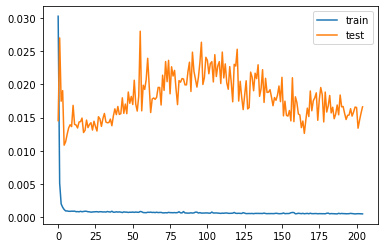

In [32]:
# evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:

predictions = model.predict(X_test)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

0.12888069334377691

In [34]:
# train set의 평균을 예측값으로 했을 때의 오차
mu = y_train.mean()
np.sqrt(np.mean((y_test - mu) ** 2))

0.6085927661966604

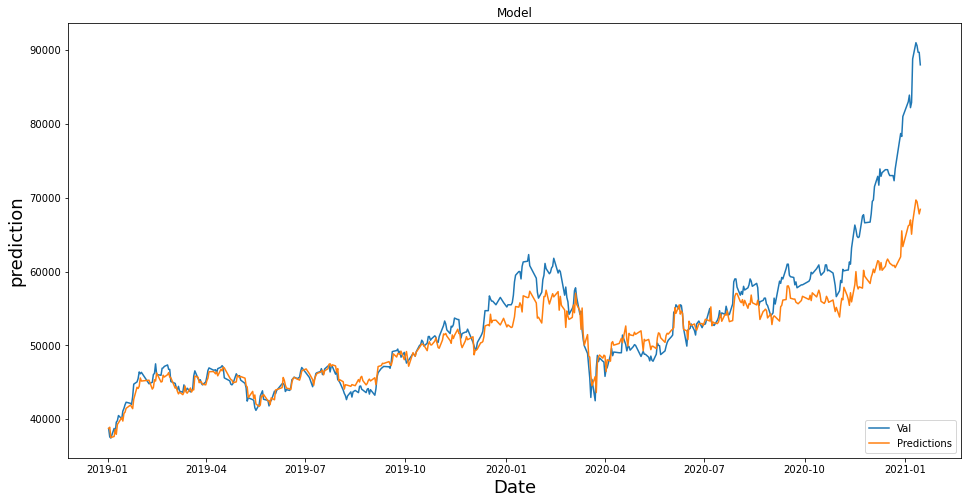

In [36]:
# 그래프로 확인
train = df_scaled[:train_date][['Close']]
valid = df_scaled[train_date:][['Close']]
valid['Predictions'] = sc2.inverse_transform(predictions)

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('prediction', fontsize=18)
#plt.plot(train)
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import datetime
date_1 = pd.to_datetime(train_date)
view_date = date_1 + datetime.timedelta(days=30)
view_date = str(view_date)
view_date = view_date[:10]
view_date

In [ ]:
# 일부분 확대
valid = df_scaled[train_date:][['Close']]
valid['Predictions'] = sc2.inverse_transform(predictions)

valid = valid[train_date:view_date]

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('prediction', fontsize=18)
#plt.plot(train)
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()